This is based on the following link:
<span style = "font-size:larger;"> <span style="color:red">
https://github.com/farakiko/particleflow/blob/master/notebooks/delphes-lrp-playground.ipynb
</span></span> <br>
Tasks(to be done under the Xai environment as [mentioned in this link](https://github.com/farakiko/xai4hep):-
- [x] Install TensorFlow
- [ ] Try to run the code in pytorch or in TensorFlow
- [ ] start integrating the lrp work (which can be found under mlpf/lrp/lrp_mlpf.py) to work for a tensorflow model instead of a pytorch model... this essentially means copying the LRP_MLPF class to the notebook and trying to get this block to run

In [1]:
import bz2, pickle
import numpy as np
import tensorflow as tf
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt

import os.path as osp
import os
import sys
from glob import glob
#pytorch libraries
import torch
# import torch.nn as nn
from torch import nn


from typing import Optional, Union


In [2]:
import sys
sys.path += ["/home/sraj/UCSD/particleflow/mlpf/"]

import tfmodel


In [3]:
!wget --no-check-certificate -nc https://zenodo.org/record/4452283/files/tev14_pythia8_ttbar_0_0.pkl.bz2


File ‘tev14_pythia8_ttbar_0_0.pkl.bz2’ already there; not retrieving.



In [4]:
data = pickle.load(bz2.BZ2File("tev14_pythia8_ttbar_0_0.pkl.bz2", "r"))


In [5]:
# 100 events in one file
len(data["X"]), len(data["ygen"])

(100, 100)

In [6]:
#Pad the number of elements to a size that's divisible by the bin size
Xs = []
ys = []

max_size = 50*128
for i in range(len(data["X"])):
    X = data["X"][i][:max_size, :]
    y = data["ygen"][i][:max_size, :]
    Xpad = np.pad(X, [(0, max_size - X.shape[0]), (0, 0)])
    ypad = np.pad(y, [(0, max_size - y.shape[0]), (0, 0)])
    Xpad = Xpad.astype(np.float32)
    ypad = ypad.astype(np.float32)
    Xs.append(Xpad)
    ys.append(ypad)
    
X = np.stack(Xs)
y = np.stack(ys)

# Test the pytorch setup for the input X


In [7]:
# defines a pytorch FCN class for particleflow 

class MLPF_FCN(nn.Module):
    """
    Showcase an example of an fully connected network pytorch model, with a skip connection, that can be explained by LRP
    """

    def __init__(self, input_dim=12, hidden_dim=2, embedding_dim=2, output_dim=2):
        super(MLPF_FCN, self).__init__()

        self.act = nn.ReLU

        self.nn1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.act(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.act(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.act(),
            nn.Linear(hidden_dim, embedding_dim),
        )
        self.nn2 = nn.Sequential(
            nn.Linear(input_dim + embedding_dim, hidden_dim),
            self.act(),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, X):
        embedding = self.nn1(X)
        return self.nn2(torch.cat([X, embedding], axis=1)), _, _

In [8]:
# defines a pytorch GNN class for particleflow 

import pickle as pkl
import os.path as osp
import os
import sys
from glob import glob

import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import Linear
from torch_scatter import scatter
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import to_dense_adj
import torch.nn.functional as F

from typing import Optional, Union
from torch_geometric.typing import OptTensor, PairTensor, PairOptTensor
from torch_geometric.data import Data, DataLoader, DataListLoader, Batch

try:
    from torch_cluster import knn
except ImportError:
    knn = None
from torch_cluster import knn_graph

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [9]:
class MLPF_GNN(nn.Module):
    """
    GNN model based on Gravnet...

    Forward pass returns
        preds: tensor of predictions containing a concatenated representation of the pids and p4
        A: dict() object containing adjacency matrices for each message passing
        msg_activations: dict() object containing activations before each message passing
    """
import torch
from torch import Tensor
    def __init__(self,
                 input_dim=12, output_dim_id=6, output_dim_p4=6,
                 embedding_dim=2, hidden_dim1=2, hidden_dim2=2,
                 num_convs=2, space_dim=4, propagate_dim=2, k=8):
        super(MLPF_GNN, self).__init__()

        # self.act = nn.ReLU
        self.act = nn.ELU

        # (1) embedding
        self.nn1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            self.act(),
            nn.Linear(hidden_dim1, hidden_dim1),
            self.act(),
            nn.Linear(hidden_dim1, hidden_dim1),
            self.act(),
            nn.Linear(hidden_dim1, embedding_dim),
        )

        self.conv = nn.ModuleList()
        for i in range(num_convs):
            self.conv.append(GravNetConv_LRP(embedding_dim, embedding_dim, space_dim, propagate_dim, k))

        # (3) DNN layer: classifiying pid
        self.nn2 = nn.Sequential(
            nn.Linear(input_dim + embedding_dim, hidden_dim2),
            self.act(),
            nn.Linear(hidden_dim2, hidden_dim2),
            self.act(),
            nn.Linear(hidden_dim2, hidden_dim2),
            self.act(),
            nn.Linear(hidden_dim2, output_dim_id),
        )

        # (4) DNN layer: regressing p4
        self.nn3 = nn.Sequential(
            nn.Linear(input_dim + output_dim_id, hidden_dim2),
            self.act(),
            nn.Linear(hidden_dim2, hidden_dim2),
            self.act(),
            nn.Linear(hidden_dim2, hidden_dim2),
            self.act(),
            nn.Linear(hidden_dim2, output_dim_p4),
        )

    def forward(self, batch):

        x0 = batch.x

        # embed the inputs
        embedding = self.nn1(x0)

        # preform a series of graph convolutions
        A = {}
        msg_activations = {}
        for num, conv in enumerate(self.conv):
            embedding, A[f'conv.{num}'], msg_activations[f'conv.{num}'] = conv(embedding)

        # predict the pid's
        preds_id = self.nn2(torch.cat([x0, embedding], axis=-1))

        # predict the p4's
        preds_p4 = self.nn3(torch.cat([x0, preds_id], axis=-1))

        return torch.cat([preds_id, preds_p4], axis=-1), A, msg_activations

In [10]:
class GravNetConv_LRP(MessagePassing):
    """
    Copied from pytorch_geometric source code, with the following edits
      a. retrieve adjacency matrix (we call A), and the activations before the message passing step (we call msg_activations)
      b. switched the execution of self.lin_s & self.lin_p so that the message passing step can substitute out of the box self.lin_s for lrp purposes
      c. used reduce='sum' instead of reduce='mean' in the message passing
      d. removed skip connection
    """

    def __init__(self, in_channels: int, out_channels: int,
                 space_dimensions: int, propagate_dimensions: int, k: int,
                 num_workers: int = 1, **kwargs):
        super().__init__(flow='source_to_target', **kwargs)

        if knn is None:
            raise ImportError('`GravNetConv` requires `torch-cluster`.')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.k = k
        self.num_workers = num_workers

        self.lin_p = Linear(in_channels, propagate_dimensions)
        self.lin_s = Linear(in_channels, space_dimensions)
        self.lin_out = Linear(propagate_dimensions, out_channels)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_s.reset_parameters()
        self.lin_p.reset_parameters()
        self.lin_out.reset_parameters()

    def forward(
            self, x: Union[Tensor, PairTensor],
            batch: Union[OptTensor, Optional[PairTensor]] = None) -> Tensor:
        """"""

        is_bipartite: bool = True
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
            is_bipartite = False

        if x[0].dim() != 2:
            raise ValueError("Static graphs not supported in 'GravNetConv'")

        b: PairOptTensor = (None, None)
        if isinstance(batch, Tensor):
            b = (batch, batch)
        elif isinstance(batch, tuple):
            assert batch is not None
            b = (batch[0], batch[1])

        # embed the inputs before message passing
        msg_activations = self.lin_p(x[0])

        # transform to the space dimension to build the graph
        s_l: Tensor = self.lin_s(x[0])
        s_r: Tensor = self.lin_s(x[1]) if is_bipartite else s_l

        edge_index = knn(s_l, s_r, self.k, b[0], b[1]).flip([0])

        edge_weight = (s_l[edge_index[0]] - s_r[edge_index[1]]).pow(2).sum(-1)
        edge_weight = torch.exp(-10. * edge_weight)  # 10 gives a better spread

        # return the adjacency matrix of the graph for lrp purposes
        A = to_dense_adj(edge_index.to('cpu'), edge_attr=edge_weight.to('cpu'))[0]  # adjacency matrix

        # message passing
        out = self.propagate(edge_index, x=(msg_activations, None),
                             edge_weight=edge_weight,
                             size=(s_l.size(0), s_r.size(0)))

        return self.lin_out(out), A, msg_activations

    def message(self, x_j: Tensor, edge_weight: Tensor) -> Tensor:
        return x_j * edge_weight.unsqueeze(1)

    def aggregate(self, inputs: Tensor, index: Tensor,
                  dim_size: Optional[int] = None) -> Tensor:
        out_mean = scatter(inputs, index, dim=self.node_dim, dim_size=dim_size,
                           reduce='sum')
        return out_mean

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, k={self.k})')

In [17]:
# from X (the input to the tensorflow model, reshape and recast as conveninet pytorch format)
pytorch_X = torch.tensor(X[:1].reshape(-1,12)) # the slicX[e [:1] picks up the first event

In [16]:
# build a simple FCN and perform forward pass
model = MLPF_FCN()
model(pytorch_X);


In [18]:
# build a GNN and perform forward pass
batch = Batch(x = pytorch_X) # recall GNN takes a batch object
model = MLPF_GNN()
model(batch);

In [20]:
# defines lrp
import pickle as pkl
import os.path as osp
import os
import sys
from glob import glob

import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU




In [21]:
class LRP_MLPF():

    """
    Extends the LRP class to act on graph datasets and GNNs based on the Gravnet layer (e.g. the MLPF model, see models.MLPF)
    The main trick is to realize that the ".lin_s" layers in Gravnet are irrelevant for explanations so shall be skipped
    The hack, however, is to substitute them precisely with the message_passing step

    Differences from standard LRP
        a. Rscores become tensors/graphs of input features per output neuron instead of vectors
        b. accomodates message passing steps by using the adjacency matrix as the weight matrix in standard LRP,
           and redistributing Rscores over the other dimension (over nodes instead of features)
    """

    def __init__(self, device, model, epsilon):

        self.device = device
        self.model = model.to(device)
        self.epsilon = epsilon  # for stability reasons in the lrp-epsilon rule (by default: a very small number)

        # check if the model has any skip connections to accomodate them
        self.skip_connections = self.find_skip_connections()
        self.msg_passing_layers = self.find_msg_passing_layers()

    """
    explanation functions
    """

    def explain(self, input, neuron_to_explain):
        """
        Primary function to call on an LRP instance to start explaining predictions.
        First, it registers hooks and runs a forward pass on the input.
        Then, it attempts to explain the whole model by looping over the layers in the model and invoking the explain_single_layer function.

        Args:
            input: tensor containing the input sample you wish to explain
            neuron_to_explain: the index for a particular neuron in the output layer you wish to explain

        Returns:
            R_tensor: a tensor/graph containing the relevance scores of the input graph for a particular output neuron
            preds: the model predictions of the input (for further plotting/processing purposes only)
            input: the input that was explained (for further plotting/processing purposes only)
        """

        # register forward hooks to retrieve intermediate activations
        # in simple words, when the forward pass is called, the following dict() will be filled with (key, value) = ("layer_name", activations)
        activations = {}

        def get_activation(name):
            def hook(model, input, output):
                activations[name] = input[0]
            return hook

        for name, module in self.model.named_modules():
            # unfold any containers so as to register hooks only for their child modules (equivalently we are demanding type(module) != nn.Sequential))
            if ('Linear' in str(type(module))) or ('activation' in str(type(module))) or ('BatchNorm1d' in str(type(module))):
                module.register_forward_hook(get_activation(name))

        # run a forward pass
        self.model.eval()
        preds, self.A, self.msg_activations = self.model(input.to(self.device))

        # get the activations
        self.activations = activations
        self.num_layers = len(activations.keys())
        self.in_features_dim = self.name2layer(list(activations.keys())[0]).in_features

        print(f'Total number of layers: {self.num_layers}')

        # initialize Rscores for skip connections (in case there are any)
        if len(self.skip_connections) != 0:
            self.skip_connections_relevance = 0

        # initialize the Rscores tensor using the output predictions
        Rscores = preds[:, neuron_to_explain].reshape(-1, 1).detach()

        # build the Rtensor which is going to be a whole graph of Rscores per node
        R_tensor = torch.zeros([Rscores.shape[0], Rscores.shape[0], Rscores.shape[1]]).to(self.device)
        for node in range(R_tensor.shape[0]):
            R_tensor[node][node] = Rscores[node]

        # loop over layers in the model to propagate Rscores backward
        for layer_index in range(self.num_layers, 0, -1):
            R_tensor = self.explain_single_layer(R_tensor, layer_index, neuron_to_explain)

        print("Finished explaining all layers.")

        if len(self.skip_connections) != 0:
            return R_tensor + self.skip_connections_relevance, preds, input

        return R_tensor, preds, input

    def explain_single_layer(self, R_tensor_old, layer_index, neuron_to_explain):
        """
        Attempts to explain a single layer in the model by propagating Rscores backwards using the lrp-epsilon rule.

        Args:
            R_tensor_old: a tensor/graph containing the Rscores, of the current layer, to be propagated backwards
            layer_index: index that corresponds to the position of the layer in the model (see helper functions)
            neuron_to_explain: the index for a particular neuron in the output layer to explain

        Returns:
            R_tensor_new: a tensor/graph containing the computed Rscores of the previous layer
        """

        # get layer information
        layer_name = self.index2name(layer_index)
        layer = self.name2layer(layer_name)

        # get layer activations (depends wether it's a message passing step)
        if layer_name in self.msg_passing_layers.keys():
            print(f"Explaining layer {self.num_layers+1-layer_index}/{self.num_layers}: MessagePassing layer")
            input = self.msg_activations[layer_name[:-6]].to(self.device).detach()
            msg_passing_layer = True
        else:
            print(f"Explaining layer {self.num_layers+1-layer_index}/{self.num_layers}: {layer}")
            input = self.activations[layer_name].to(self.device).detach()
            msg_passing_layer = False

        # run lrp
        if 'Linear' in str(layer):
            R_tensor_new = self.eps_rule(self, layer, layer_name, input, R_tensor_old, neuron_to_explain, msg_passing_layer)
            print('- Finished computing Rscores')
            return R_tensor_new
        else:
            if 'activation' in str(layer):
                print(f"- skipping layer because it's an activation layer")
            elif 'BatchNorm1d' in str(layer):
                print(f"- skipping layer because it's a BatchNorm layer")
            print(f"- Rscores do not need to be computed")
            return R_tensor_old

    """
    lrp-epsilon rule
    """

    @staticmethod
    def eps_rule(self, layer, layer_name, x, R_tensor_old, neuron_to_explain, msg_passing_layer):
        """
        Implements the lrp-epsilon rule presented in the following reference: https://doi.org/10.1007/978-3-030-28954-6_10.

        Can accomodate message_passing layers if the adjacency matrix and the activations before the message_passing are provided.
        The trick (or as we like to call it, the message_passing hack) is in
            a. using the adjacency matrix as the weight matrix in the standard lrp rule
            b. transposing the activations to distribute the Rscores over the other dimension (over nodes instead of features)

        Args:
            layer: a torch.nn module with a corresponding weight matrix W
            x: vector containing the activations of the previous layer
            R_tensor_old: a tensor/graph containing the Rscores, of the current layer, to be propagated backwards
            neuron_to_explain: the index for a particular neuron in the output layer to explain

        Returns:
            R_tensor_new: a tensor/graph containing the computed Rscores of the previous layer
        """

        torch.cuda.empty_cache()

        if msg_passing_layer:   # message_passing hack
            x = torch.transpose(x, 0, 1)               # transpose the activations to distribute the Rscores over the other dimension (over nodes instead of features)
            W = self.A[layer_name[:-6]].detach().to(self.device)       # use the adjacency matrix as the weight matrix
        else:
            W = layer.weight.detach()  # get weight matrix
            W = torch.transpose(W, 0, 1)    # sanity check of forward pass: (torch.matmul(x, W) + layer.bias) == layer(x)

        # for the output layer, pick the part of the weight matrix connecting only to the neuron you're attempting to explain
        if layer == list(self.model.modules())[-1]:
            W = W[:, neuron_to_explain].reshape(-1, 1)

        # (1) compute the denominator
        denominator = torch.matmul(x, W) + self.epsilon
        # (2) scale the Rscores
        if msg_passing_layer:  # message_passing hack
            R_tensor_old = torch.transpose(R_tensor_old, 1, 2)
        scaledR = R_tensor_old / denominator
        # (3) compute the new Rscores
        R_tensor_new = torch.matmul(scaledR, torch.transpose(W, 0, 1)) * x

        # checking conservation of Rscores for a given random node (# 17)
        rtol = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
        for tol in rtol:
            if (torch.allclose(R_tensor_new[17].sum(), R_tensor_old[17].sum(), rtol=tol)):
                print(f'- Rscores are conserved up to relative tolerance {str(tol)}')
                break

        if layer in self.skip_connections:
            # set aside the relevance of the input_features in the skip connection
            # recall: it is assumed that the skip connections are defined in the following order torch.cat[(input_features, ...)] )
            self.skip_connections_relevance = self.skip_connections_relevance + R_tensor_new[:, :, :self.in_features_dim]
            return R_tensor_new[:, :, self.in_features_dim:]

        if msg_passing_layer:  # message_passing hack
            return torch.transpose(R_tensor_new, 1, 2)

        return R_tensor_new

    """
    helper functions
    """

    def index2name(self, layer_index):
        """
        Given the index of a layer (e.g. 3) returns the name of the layer (e.g. .nn1.3)
        """
        layer_name = list(self.activations.keys())[layer_index - 1]
        return layer_name

    def name2layer(self, layer_name):
        """
        Given the name of a layer (e.g. .nn1.3) returns the corresponding torch module (e.g. Linear(...))
        """
        for name, module in self.model.named_modules():
            if layer_name == name:
                return module

    def find_skip_connections(self):
        """
        Given a torch model, retuns a list of layers with skip connections... the elements are torch modules (e.g. Linear(...))
        """
        explainable_layers = []
        for name, module in self.model.named_modules():
            if 'lin_s' in name:     # for models that are based on Gravnet, skip the lin_s layers
                continue
            if ('Linear' in str(type(module))):
                explainable_layers.append(module)

        skip_connections = []
        for layer_index in range(len(explainable_layers) - 1):
            if explainable_layers[layer_index].out_features != explainable_layers[layer_index + 1].in_features:
                skip_connections.append(explainable_layers[layer_index + 1])

        return skip_connections

    def find_msg_passing_layers(self):
        """
        Returns a list of ".lin_s" layers from model.named_modules() that shall be substituted with message passing
        """
        msg_passing_layers = {}
        for name, module in self.model.named_modules():
            if 'lin_s' in name:     # for models that are based on Gravnet, replace the .lin_s layers with message_passing
                msg_passing_layers[name] = {}

        return msg_passing_layers

In [ ]:
# test lrp for the FCN model
model = MLPF_FCN()

lrp_instance = LRP_MLPF('cpu', model, epsilon=1e-9)
Rtensor, pred, inputt = lrp_instance.explain(pytorch_X, neuron_to_explain=0)

Total number of layers: 13
Explaining layer 1/13: Linear(in_features=2, out_features=2, bias=True)
- Rscores are conserved up to relative tolerance 1e-05
- Finished computing Rscores
Explaining layer 2/13: ReLU()
- Rscores do not need to be computed
Explaining layer 3/13: Linear(in_features=14, out_features=2, bias=True)
- Rscores are conserved up to relative tolerance 1e-05
- Finished computing Rscores
Explaining layer 4/13: Linear(in_features=2, out_features=2, bias=True)
- Finished computing Rscores
Explaining layer 5/13: ReLU()
- Rscores do not need to be computed
Explaining layer 6/13: BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
- skipping layer because it's a BatchNorm layer
- Rscores do not need to be computed
Explaining layer 7/13: Linear(in_features=2, out_features=2, bias=True)
- Rscores are conserved up to relative tolerance 1e-05
- Finished computing Rscores
Explaining layer 8/13: ReLU()
- Rscores do not need to be computed
Explaining laye

In [1]:
# test lrp for the GNN model
model = MLPF_GNN()

lrp_instance = LRP_MLPF('cpu', model, epsilon=1e-9)
Rtensor, pred, inputt = lrp_instance.explain(batch, neuron_to_explain=0)

NameError: name 'MLPF_GNN' is not defined

# Back to the tensorflow setup


In [11]:
#Get the first event
input_classes = np.unique(X[:, :, 0].flatten())
output_classes = np.unique(y[:, :, 0].flatten())
num_output_classes = len(output_classes)

In [12]:
input_classes

array([0., 1., 2.], dtype=float32)

In [13]:
output_classes

array([0., 1., 2., 3., 4., 5.], dtype=float32)

In [14]:
def transform_target(y):
    return {
        "cls": tf.one_hot(tf.cast(y[:, :, 0], tf.int32), num_output_classes),
        "charge": y[:, :, 1:2],
        "pt": y[:, :, 2:3],
        "eta": y[:, :, 3:4],
        "sin_phi": y[:, :, 4:5],
        "cos_phi": y[:, :, 5:6],
        "energy": y[:, :, 6:7],
    }
yt = transform_target(y)

2022-06-06 11:49:11.398075: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [15]:
from tfmodel.model import PFNetDense


In [16]:
msk_true_particle = y[:, :, 0]!=0

In [17]:
np.unique(y[msk_true_particle][:, 0], return_counts=True)

(array([1., 2., 3., 4., 5.], dtype=float32),
 array([263996,  93508, 133732,    912,    278]))

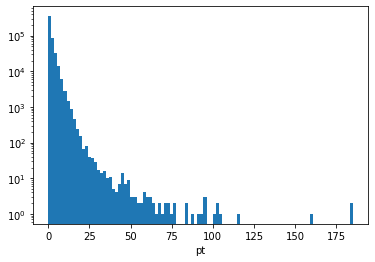

In [18]:
plt.hist(yt["pt"][msk_true_particle].flatten(), bins=100);
plt.xlabel("pt")
plt.yscale("log")

Text(0.5, 0, 'eta')

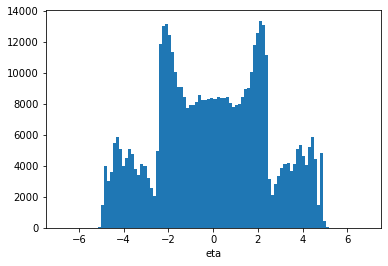

In [19]:
plt.hist(yt["eta"][msk_true_particle].flatten(), bins=100);
plt.xlabel("eta")

Text(0.5, 0, 'sin phi')

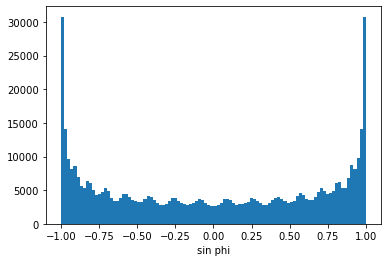

In [20]:
plt.hist(yt["sin_phi"][msk_true_particle].flatten(), bins=100);
plt.xlabel("sin phi")

Text(0.5, 0, 'cos phi')

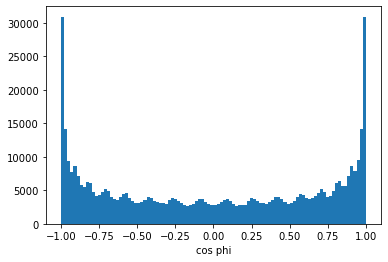

In [21]:
plt.hist(yt["cos_phi"][msk_true_particle].flatten(), bins=100);
plt.xlabel("cos phi")

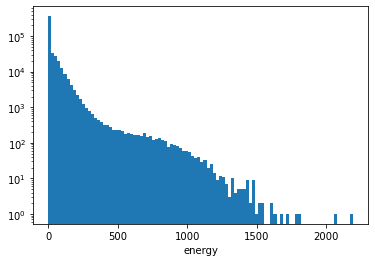

In [22]:
plt.hist(yt["energy"][msk_true_particle].flatten(), bins=100);
plt.xlabel("energy")
plt.yscale("log")

In [23]:
model = PFNetDense(
    num_input_classes=len(input_classes),
    num_output_classes=len(output_classes),
    activation=tf.nn.elu,
    hidden_dim=128,
    bin_size=128,
    input_encoding="default",
    multi_output=True,
)


TypeError: getattr(): attribute name must be string

In [24]:
model = PFNetDense(
    num_input_classes=len(input_classes),
    num_output_classes=len(output_classes),
    activation=tf.nn.elu,
    hidden_dim=128,
    bin_size=128,
    input_encoding="default",
    multi_output=True,
)

# #temporal weight mode means each input element in the event can get a separate weight
model.compile(
    loss={
        "cls": tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        "charge": tf.keras.losses.MeanSquaredError(),
        "pt": tf.keras.losses.MeanSquaredError(),
        "energy": tf.keras.losses.MeanSquaredError(),
        "eta": tf.keras.losses.MeanSquaredError(),
        "sin_phi": tf.keras.losses.MeanSquaredError(),
        "cos_phi": tf.keras.losses.MeanSquaredError()
    },
    optimizer="adam",
    sample_weight_mode="temporal"
)

TypeError: getattr(): attribute name must be string

In [36]:
model(X[:1])

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [37]:
model.fit(X, yt, epochs=2, batch_size=5)


AttributeError: 'MLPF_FCN' object has no attribute 'fit'

In [39]:
ypred = model.predict(X, batch_size=5)


AttributeError: 'MLPF_FCN' object has no attribute 'predict'

In [40]:
#index of the class prediction output values
pred_id_offset = len(output_classes)
ypred_ids_raw = ypred["cls"]

NameError: name 'ypred' is not defined

In [41]:
sklearn.metrics.confusion_matrix(
    np.argmax(ypred_ids_raw, axis=-1).flatten(),
    np.argmax(yt["cls"], axis=-1).flatten(), labels=output_classes
)

NameError: name 'ypred_ids_raw' is not defined

In [42]:
msk_particles = (X[:, :, 0]!=0)
plt.scatter(
    ypred["eta"][msk_particles].flatten(),
    yt["eta"][msk_particles].flatten(), marker=".")

NameError: name 'ypred' is not defined